In [1]:
import os
import cv2 as cv
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [3]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Combine everything
TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5,TRAIN_PATH6))
MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6))
train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6))
mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6))

In [49]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)
print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if n in range(899,977):
        img = img[:,:,1]
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

Getting features and labels from images unreshaped... 


100%|██████████| 3780/3780 [2:44:36<00:00,  4.51s/it]  


In [3]:
# Load the data NON SHUFFLED
dat = np.load("ALLFEATURES-Copy1.npy")
print(dat.shape)

(854328232, 10)


In [13]:
# Shuffle the data DON'T RUN
#np.random.shuffle(dat)
dat = np.load('SHUFFLED.npy')

In [4]:
# Load Shuffled data
dat = np.load('SHUFFLED.npy')
feat = dat[0:800000,0:9]
labels = dat[0:800000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)

(800000, 9)
(800000,)


In [9]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('model-extra256layer-10Feb2019.h5', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.25, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

Train on 600000 samples, validate on 200000 samples
Epoch 1/50
600000/600000 [==============================] - 62s 104us/step - loss: 0.2850 - acc: 0.8915 - val_loss: 0.3064 - val_acc: 0.9024

Epoch 00001: val_loss improved from inf to 0.30635, saving model to model-extra256layer-10Feb2019.h5
Epoch 2/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2563 - acc: 0.9046 - val_loss: 0.2755 - val_acc: 0.9119

Epoch 00002: val_loss improved from 0.30635 to 0.27554, saving model to model-extra256layer-10Feb2019.h5
Epoch 3/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2488 - acc: 0.9071 - val_loss: 0.2777 - val_acc: 0.9102

Epoch 00003: val_loss did not improve from 0.27554
Epoch 4/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2441 - acc: 0.9094 - val_loss: 0.2731 - val_acc: 0.9082

Epoch 00004: val_loss improved from 0.27554 to 0.27311, saving model to model-extra256layer-10Feb2019.h5
Epoch 5/50
600000/


Epoch 00041: val_loss did not improve from 0.25790
Epoch 42/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2279 - acc: 0.9141 - val_loss: 0.2807 - val_acc: 0.8964

Epoch 00042: val_loss did not improve from 0.25790
Epoch 43/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2276 - acc: 0.9142 - val_loss: 0.2798 - val_acc: 0.8959

Epoch 00043: val_loss did not improve from 0.25790
Epoch 44/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2281 - acc: 0.9141 - val_loss: 0.3006 - val_acc: 0.8818

Epoch 00044: val_loss did not improve from 0.25790
Epoch 45/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2275 - acc: 0.9144 - val_loss: 0.2816 - val_acc: 0.8969

Epoch 00045: val_loss did not improve from 0.25790
Epoch 46/50
600000/600000 [==============================] - 62s 103us/step - loss: 0.2275 - acc: 0.9139 - val_loss: 0.2793 - val_acc: 0.8980

Epoch 00046: val_loss did not

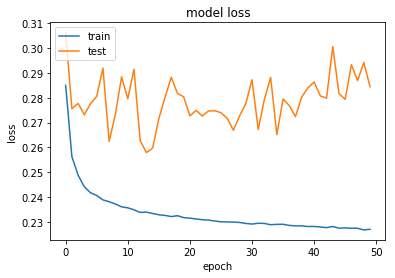

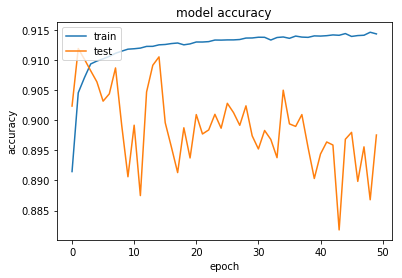

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 3780
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes
-------------------------------------------------------------
#    Time sec      Tr_acc     Tr_loss      Vl_acc     Vl_loss
-------------------------------------------------------------
0   62.567800   0.891500    0.285000    0.902400    0.306353
1   61.732000   0.904600    0.256300    0.911900    0.275544
2   61.779000   0.907100    0.248800    0.910200    0.277712
3   61.898700   0.909400    0.244100    0.908200    0.273106
4   61.738700   0.909900    0.241700    0.906400    0.277549
5   61.763000   0.910200    0.240600    0.903200    0.280519
6   61.725500   0.910600    0.238800    0.904400    0.291933
7   61.789200   0.911200    0.238100    0.908700    0.262424
8   61.726100   0.911500    0.237200    0.899100    0.273248
9   61.48

In [10]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [11]:
# Evaluate the model
model = load_model('model-extra256layer-10Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/testing_data/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/ground_truth/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = ABD_PATH + abd_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[0]
img = imread(path)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)
    if n in range(899,977):
        img = img[:,:,1]
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))
   
X = dat[:,0:9]
Y = dat[:,9]
Y = (Y > 0).astype(np.uint8) 

Getting features and labels from images unreshaped... 


100%|██████████| 50/50 [00:09<00:00,  3.65it/s]


In [12]:
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

47574033/47574033 [==============================] - 2390s 50us/step

acc: 94.93%
